# Manipulate bathymetry data

There is very high resolution bathymetry data [available](http://www.ngdc.noaa.gov/mgg/coastal/) for Galveston Bay. It is too large to use on a lightweight machine, so I decimated it, taking every fifth cell, and saved it as a .npz file called `bathy_every_fifth.npz`. This has been saved to Google Drive folder "Harvey Flooding" for sharing.

This notebook produces bathymetry files for all of Galveston Bay, the main bay alone, the west bay, and the east bay, all in .npz format. These files have already been saved into the `drive_data` directory.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import date2num
import numpy as np
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import os
from collections import OrderedDict
from matplotlib.path import Path
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

base = 'drive_data/bathy/'

/Users/kthyng/miniconda3/envs/cart/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
# create arrays of lon/lat
num = 10261
dd = 9.2592589999999e-005
xllcorner = -95.250046296295
yllcorner = 28.849953716305
x = np.linspace(xllcorner, xllcorner+dd*num, num)
y = np.linspace(yllcorner, yllcorner+dd*num, num)
lon, lat = np.meshgrid(x, y)

# use every fifth bathymetry point
# bathymetry was decimated on hafen and scp'ed to here
# same as the file in `Galveston_DEM_1072`
bathy = np.load(base + 'bathy_every_fifth.npz')['bathy'][::-1,:]
lon = lon[::5, ::5]
lat = lat[::5, ::5]

# Leave outside rows and columns off of dataset so that I can calculate spatially-
# dependent dx and dy values
bathy = bathy[1:-1,1:-1]; lon = lon[1:-1,1:-1]; lat = lat[1:-1,1:-1];

## Galveston Bay bathymetry

Separate the bay bathymetry out from the topography, and retain only values in the bay.

### Remove more extra bathy by hand

In [5]:
# outline bay
fname = base + 'bathy_bay_outline.npz'

if not os.path.exists(fname):  # manual removal
    %matplotlib auto
    fig, ax = plt.subplots(figsize=(8,7))
    mappable = ax.contourf(lon, lat, bathy, cmap=cmo.deep_r); 
    pts = plt.ginput(n=0, timeout=0)
    np.savez(fname, pts=pts)
else:
    ptsout = np.load(fname)['pts']

In [6]:
# remove extraneous points outside path
fnameclean = base + 'bathy_galv_clean.npz'

if not os.path.exists(fnameclean):
    
    # remove topography (>0)
    inds = bathy>0
    bathy[inds] = np.nan

    pathout = Path(ptsout)
    inds = ~pathout.contains_points(np.vstack((lon.flatten(), lat.flatten())).T).reshape(lon.shape)
    bathy[inds] = np.nan

    # Find cell lengths
    pc = cartopy.crs.PlateCarree()
    laea = cartopy.crs.LambertAzimuthalEqualArea()
    pts = laea.transform_points(pc, lon, lat)
    xp = pts[:,:,0]; yp  = pts[:,:,1]
    dx = np.diff(xp, axis=1).mean()  # are all within about a meter of each other
    dy = np.diff(yp, axis=0).mean()  # are all within about a meter of each other

    np.savez(fnameclean, bathy=bathy, lon=lon, lat=lat, dx=dx, dy=dy)

else:
    bathy = np.load(fnameclean)['bathy']

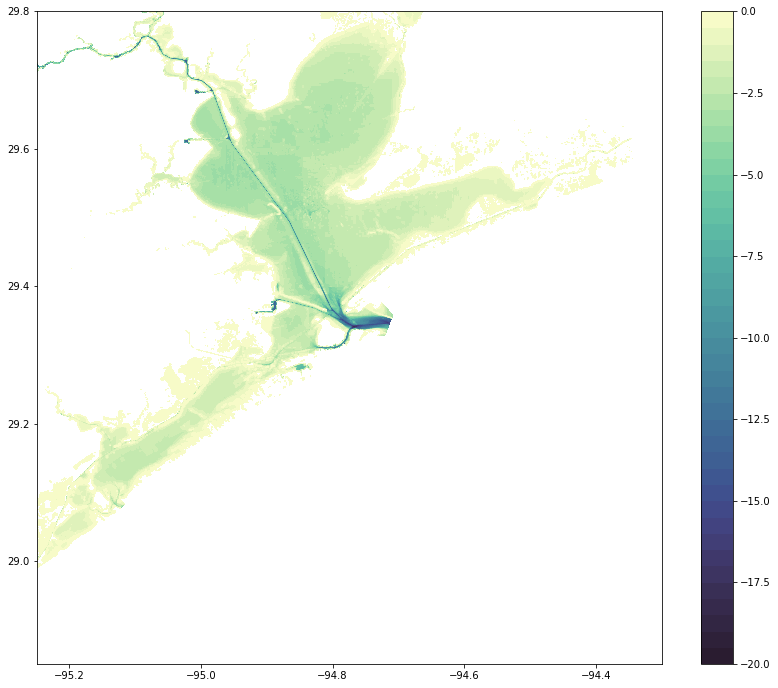

In [7]:
# now what does it look like
%matplotlib inline
fig, ax = plt.subplots(figsize=(14,12))
mappable = ax.contourf(lon, lat, bathy, 40, cmap=cmo.deep_r); 
fig.colorbar(mappable)

## West bay separate from rest (Main) bay

In [8]:
fname = base + 'bathy_westbay_outline.npz'

if not os.path.exists(fname):  # manual removal
    %matplotlib auto
    fig, ax = plt.subplots(figsize=(10, 8))
    mappable = ax.contourf(lon, lat, bathy, cmap=cmo.deep_r); 
    pts = plt.ginput(n=0, timeout=0)
    np.savez(fname, pts=pts)
else:
    ptswest = np.load(fname)['pts']

In [9]:
fnamewest = base + 'bathy_galv_west.npz'
fnamemain = base + 'bathy_galv_main.npz'

if not os.path.exists(fnamewest):

    # remove extraneous points outside west bay path to get separate
    bathyw = bathy.copy()  # west bay bathy
    bathym = bathy.copy()  # rest of bay bathy

    pathwest = Path(ptswest)
    inds = ~pathwest.contains_points(np.vstack((lon.flatten(), lat.flatten())).T).reshape(lon.shape)
    bathyw[inds] = np.nan
    inds = pathwest.contains_points(np.vstack((lon.flatten(), lat.flatten())).T).reshape(lon.shape)
    bathym[inds] = np.nan

    np.savez(fnamewest, bathy=bathyw, lon=lon, lat=lat, dx=dx, dy=dy)
    np.savez(fnamemain, bathy=bathym, lon=lon, lat=lat, dx=dx, dy=dy)

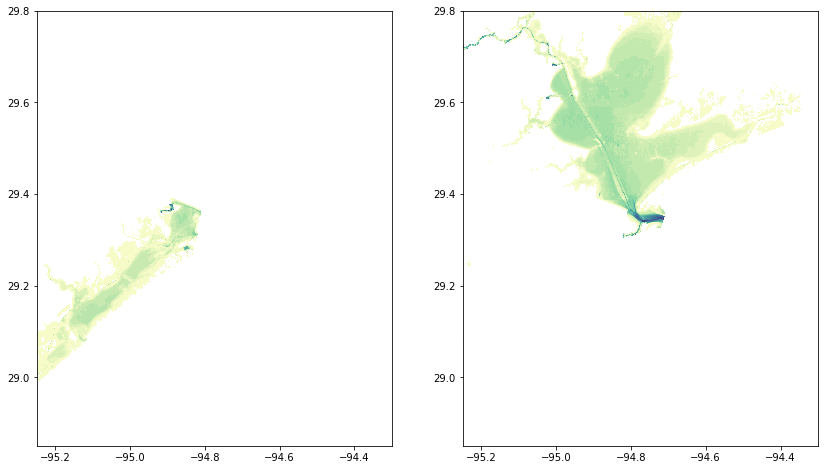

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14,8))
axes[0].contourf(lon, lat, bathyw, 40, cmap=cmo.deep_r); 
mappable = axes[1].contourf(lon, lat, bathym, 40, cmap=cmo.deep_r); 

# Surface area, depth, volume

## All of Galveston Bay

Assuming that there wasn't a significant amount of new land flooded.

In [120]:
# surface area
A = np.nansum(~np.isnan(bathy)*dx*dy)  # m^2

# average depth
H = -np.nanmean(bathy)  # m

# average volume
Vall = (A*H)/1000**3  # km^3

print('Full bay area: %d km^2, average depth: %2.2f m, volume: %2.2f km^3' % (A/(1000**2), H, Vall))

Full bay area: 1197 km^2, average depth: 2.18 m, volume: 2.62 km^3


## Main bay

In [108]:
# surface area
A = np.nansum(~np.isnan(bathym)*dx*dy)  # m^2

# average depth
H = -(np.nansum(bathym))/((~np.isnan(bathym)).sum())  # m

# average volume
V = (A*H)/1000**3  # km^3

print('Main bay area: %d km^2, average depth: %2.2f m, volume: %2.2f km^3' % (A/(1000**2), H, V))

Main bay area: 896 km^2, average depth: 2.47 m, volume: 2.22 km^3


## West Bay

In [119]:
# surface area
A = np.nansum(~np.isnan(bathyw)*dx*dy)  # m^2

# average depth
H = -(np.nansum(bathyw))/((~np.isnan(bathyw)).sum())  # m

# average volume
V = (A*H)/1000**3  # km^3

print('West bay area: %d km^2, average depth: %2.2f m, volume: %2.2f km^3' % (A/(1000**2), H, V))
print('The West Bay volume is %2d%% of the full bay volume' % (V/Vall*100))

West bay area: 301 km^2, average depth: 1.33 m, volume: 0.40 km^3
The West Bay volume is 15% of the full bay volume
